# Regression (intensity)

### impoer necessary libraries

In [2]:
import gensim
#from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from resources.arabic_preprocessing import Arabic_preprocessing
from nltk.stem.arlstem import ARLSTem
import editdistance as lv  # levenshtein (edit) distance (to install: pip install editdistance)

C:\Users\oae15\AppData\Local\Continuum\anaconda3\envs\ML\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### fix seed for reproducibility

In [3]:
seed = 222
np.random.seed(seed)

### define utility functions to be used later

In [4]:
# average embeddings of words which has edit distance of 1 with a particular word
def get_similar_words_embeddings(word, words_embeddings):
    sim_1 = []
    for em in words_embeddings.wv.vocab.keys():
        if lv.eval(word, em) == 1:
            sim_1.append(em)
    if len(sim_1) == 0: return False, None # no similar words
    feature_vec = np.zeros((300,), dtype="float32")
    for em in sim_1:
        feature_vec = np.add(feature_vec, words_embeddings.wv[em])
    np.seterr(divide='ignore', invalid='ignore')
    feature_vec = np.divide(feature_vec, len(sim_1))
    f = len(sim_1) > 0
    return f, feature_vec

# convert sentence (tweet) to embeddings vector by averaging words embeddings
# params: word embeddings (Word2Vec) - sentence (str)
# returns numpy array(300,) of sentence embeddings
def featurize(words_embeddings, sentence, stemmer=None):
    """average words' vectors"""
    feature_vec = np.zeros((300,), dtype="float32")
    words = sentence.split(' ')
    retrieved_words = 0
    for token in words:
        if token in words_embeddings.wv: # the word exists in the pre-trained tweeter embeddings
            feature_vec = np.add(feature_vec, words_embeddings.wv[token])
            retrieved_words += 1
        elif stemmer is not None and stemmer.stem(token) in words_embeddings.wv: # the stem of the word exists in the pre-trained tweeter embeddings
            feature_vec = np.add(feature_vec, words_embeddings.wv[stemmer.stem(token)])
            retrieved_words += 1
        else:
            similar_words, similar_words_embeddings = get_similar_words_embeddings(token, words_embeddings)
            if similar_words: # there are similar words with min edit distance of 1
                feature_vec = np.add(feature_vec, similar_words_embeddings)
                retrieved_words += 1
    np.seterr(divide='ignore', invalid='ignore')
    feature_vec = np.divide(feature_vec, retrieved_words)
    return feature_vec

# reads dataset and returns preprocessed tweets and labels (scores) as numpy arrays
def read_and_preprocess_date_from_file(train_or_test, preprocess):
    sample=pd.read_csv('data/sentiment/2018-Valence-reg-Ar-' + train_or_test + '.txt', delimiter='\t', skiprows=1, header=None, names=['index', 'tweet','valence','score'])
    sample['tweet'] = sample['tweet'].apply(lambda x : prep.preprocess_arabic_text(x, stem=False, replace_emojis=True, normalize_arabic=True))
    X = sample['tweet'].values
    y = sample['score'].values
    return X, y

def get_train_test(preprocess, word_embeddings, stemmer):
    X1, y1 = read_and_preprocess_date_from_file('train', preprocess)
    X2, y2 = read_and_preprocess_date_from_file('dev', preprocess)
    X1 = np.array([featurize(word_embeddings, tweet, stemmer) for tweet in X1])
    X2 = np.array([featurize(word_embeddings, tweet, stemmer) for tweet in X2])
    return X1, y1, X2, y2

def count_embeddings(words_embeddings, tweets_list, stemmer):
    total, count, count_stem = 0, 0, 0
    for tweet in tweets_list:
        for word in tweet.split():
            if word in words_embeddings.wv:
                count += 1
            elif stemmer.stem(word) in words_embeddings.wv:
                count_stem += 1
            total += 1
    return total, count, count_stem

### prepare training & test data

In [38]:
# load the embeddings models
tweeter_embeddings = gensim.models.Word2Vec.load('resources/Twt-SG') # tweeter
#emoji_embeddings = KeyedVectors.load_word2vec_format('C:\\Users\\oae15\\Downloads\\Compressed\\emoji2vec.txt', binary=False) # emojis
prep = Arabic_preprocessing()
stemmer = ARLSTem()

In [56]:
# prepare train & test data
X_train, y_train, X_test, y_test = get_train_test(prep, tweeter_embeddings, stemmer)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(np.any(np.isnan(X_train)), np.any(np.isnan(X_test))) # make sure there is no missing data

(932, 300) (932,) (138, 300) (138,)
False False


### Ridge

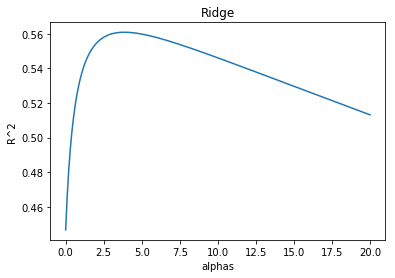

In [57]:
alphas = np.arange(0,20.1,0.1)
r2 = []
max_r2, best_alpha = 0, 0
for alpha in alphas:
    model = Ridge(alpha=alpha, random_state=seed)
    model.fit(X_train, y_train) # Train the model using the training sets
    r = model.score(X_test, y_test) # Evaluate the model
    if r > max_r2: max_r2, best_alpha = r, alpha
    r2.append(r)

# plot R^2 with respect to different values of alpha
plt.plot(alphas,r2)
plt.xlabel('alphas')
plt.ylabel('R^2')
plt.title('Ridge')
plt.show()

In [58]:
print('maximum R^2: ', max_r2)
print('Best alpha: ', best_alpha)

best_ridge_model = Ridge(alpha=best_alpha, random_state=seed)
best_ridge_model.fit(X_train, y_train) # Train the model using the training sets
y_pred = best_ridge_model.predict(X_test) # Make predictions using the testing set
best_ridge_model_pearson = pearsonr(y_test, y_pred)[0]
print('Pearson score = ' + str(best_ridge_model_pearson))

maximum R^2:  0.56087362791
Best alpha:  3.9
Pearson score = 0.750843188366


In [59]:
model = Ridge(alpha=best_alpha)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(scores)

[ 0.65516679  0.61457716  0.75115571  0.72590604  0.63799319  0.58999453
  0.60160096  0.6925463   0.63608915  0.65082112]


### SVR

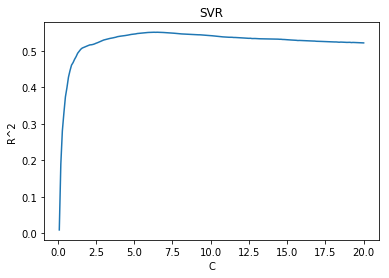

In [60]:
Cs = np.arange(0.1,20.1,0.1)
r2 = []
max_r2, best_C = 0, 0
for c in Cs:
    model = SVR(C=c)
    model.fit(X_train, y_train) # Train the model using the training sets
    r = model.score(X_test, y_test) # Evaluate the model
    if r > max_r2: max_r2, best_C = r, c
    r2.append(r)

# plot R^2 with respect to different values of C
plt.plot(Cs,r2)
plt.xlabel('C')
plt.ylabel('R^2')
plt.title('SVR')
plt.show()

In [61]:
print('maximum R^2: ', max_r2)
print('Best C: ', best_C)

best_svr_model = SVR(C=best_C)
best_svr_model.fit(X_train, y_train) # Train the model using the training sets
y_pred = best_svr_model.predict(X_test) # Make predictions using the testing set
best_svr_model_pearson = pearsonr(y_test, y_pred)[0]
print('Pearson score = ' + str(best_svr_model_pearson))

maximum R^2:  0.551421868363
Best C:  6.5
Pearson score = 0.746143216157


In [70]:
model = SVR(C=best_C)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(scores)

[ 0.58493495  0.38779237  0.36575951  0.49758331  0.40642701  0.3378256
  0.49620479  0.31272056  0.50064132  0.44326194]


### Random Forest

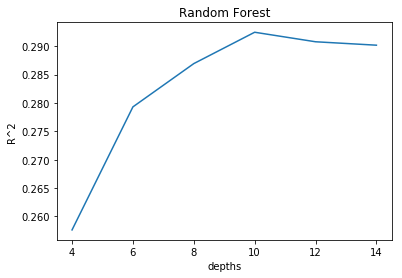

In [23]:
depths = np.arange(4,15,2)
r2 = []
max_r2, best_depth = 0, 0
for depth in depths:
    model = RandomForestRegressor(n_estimators=1000, max_depth=depth) # , random_state=seed
    model.fit(X_train, y_train) # Train the model using the training sets
    r = model.score(X_test, y_test)
    if r > max_r2: max_r2, best_depth = r, depth
    r2.append(r)

# plot R^2 with respect to different values of depth
plt.plot(depths,r2)
plt.xlabel('depths')
plt.ylabel('R^2')
plt.title('Random Forest')
plt.show()

In [10]:
#print('maximum R^2: ', max_r2)
#print('Best depth: ', best_depth)

best_random_forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=seed)
best_random_forest_model.fit(X_train, y_train) # Train the model using the training sets
y_pred = best_random_forest_model.predict(X_test) # Make predictions using the testing set
best_random_forest_model_pearson = pearsonr(y_test, y_pred)[0]
print('Pearson score = ' + str(best_random_forest_model_pearson))

Pearson score = 0.608943726499


### manual Ensemble

In [64]:
ensemble_models = [best_ridge_model, best_svr_model, best_random_forest_model]
avg_pred = np.zeros(X_test.shape[0])
for model in ensemble_models:
    pred = model.predict(X_test)
    avg_pred = np.add(avg_pred, pred)
avg_pred = avg_pred / len(ensemble_models)
pearson = pearsonr(y_test, avg_pred)
print('Pearson score = ' + str(pearson[0]))

Pearson score = 0.900436402777


### manual wieghted Ensemble

In [65]:
ensemble_models = [best_ridge_model, best_svr_model, best_random_forest_model]
ps, pred_list = [], []
for model in ensemble_models:
    pred = model.predict(X_test)
    pred_list.append(pred)
    pearson = pearsonr(y_test, pred)
    ps.append(pearson[0])

ps = np.exp(ps) / np.exp(ps).sum()

avg_pred = []
for i in range(len(ps)):
    p = pred_list[i]
    avg_pred.append(p*ps[i])

avg = np.zeros(X_test.shape[0])
for a in avg_pred:
    avg = np.add(avg, a)

pearson = pearsonr(y_test, avg)
print(pearson[0])

0.906013618257


### retrain on all data (training & test) with best tuned parameters
### Save best models to file to load them later so we do not train and tune again

In [62]:
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)

best_ridge_model = Ridge(alpha=best_alpha, random_state=seed)
best_ridge_model.fit(X, y)

best_svr_model = SVR(C=best_C)
best_svr_model.fit(X, y)

best_random_forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=seed)
best_random_forest_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=222, verbose=0, warm_start=False)

In [63]:
from sklearn.externals import joblib

joblib.dump(best_ridge_model, 'models/final/task_3_sentiment_embeddings_ridge.sav')
joblib.dump(best_svr_model, 'models/final/task_3_sentiment_embeddings_svr.sav')
joblib.dump(best_random_forest_model, 'models/final/task_3_sentiment_embeddings_random_forest.sav')

# to load models:
# load the model from disk
#best_ridge_model = joblib.load('best_ridge_model_using_embeddings.sav')

['models/final/task_3_sentiment_embeddings_random_forest.sav']

In [6]:
def ensemble_predict(models, X):
    avg_pred = np.zeros(X.shape[0])
    for model in models:
        pred = model.predict(X)
        avg_pred = np.add(avg_pred, pred)
    avg_pred = avg_pred / len(models)
    return avg_pred

# load the embeddings models
tweeter_embeddings = gensim.models.Word2Vec.load('resources/Twt-SG') # tweeter
#emoji_embeddings = KeyedVectors.load_word2vec_format('C:\\Users\\oae15\\Downloads\\Compressed\\emoji2vec.txt', binary=False) # emojis
prep = Arabic_preprocessing()
stemmer = ARLSTem()

#prepare dataset
df=pd.read_csv('data/sentiment/2018-Valence-reg-Ar-test.txt', delimiter='\t', header=0)
df['Tweet_preprocessed'] = df['Tweet'].apply(lambda x : prep.preprocess_arabic_text(x, stem=False, replace_emojis=True, normalize_arabic=True))
X = df['Tweet_preprocessed'].values
X = np.array([featurize(tweeter_embeddings, tweet, stemmer) for tweet in X])

from sklearn.externals import joblib

#load models
ridge = joblib.load('models/final/task_3_sentiment_embeddings_ridge.sav')
svr = joblib.load('models/final/task_3_sentiment_embeddings_svr.sav')
random_forest = joblib.load('models/final/task_3_sentiment_embeddings_random_forest.sav')

models = [ridge, svr, random_forest]
y_pred = ensemble_predict(models, X)
df['Intensity Score'] = y_pred
df['Intensity Score'] = df['Intensity Score'].apply(lambda x : float(format(x, '1.3f')))
df = df.drop(['Tweet_preprocessed'], axis=1)
df.to_csv('data/pred/V-reg_ar_pred.txt', sep='\t', index=False, header=True)

NameError: name 'joblib' is not defined

In [1]:
from sklearn.externals import joblib

#load models
ridge = joblib.load('models/final/task_3_sentiment_embeddings_ridge.sav')
svr = joblib.load('models/final/task_3_sentiment_embeddings_svr.sav')
random_forest = joblib.load('models/final/task_3_sentiment_embeddings_random_forest.sav')

print(ridge.alpha)
print(svr.C)
print(random_forest.max_depth)

3.9
6.5
10
